总的 RMSE: 4.622063078805732
水深大于 15 的 RMSE: 5.434818482982612
水深小于 15 的 RMSE: 1.347556198021258
误差在0-3区间的 RMSE: 1.409299292364893


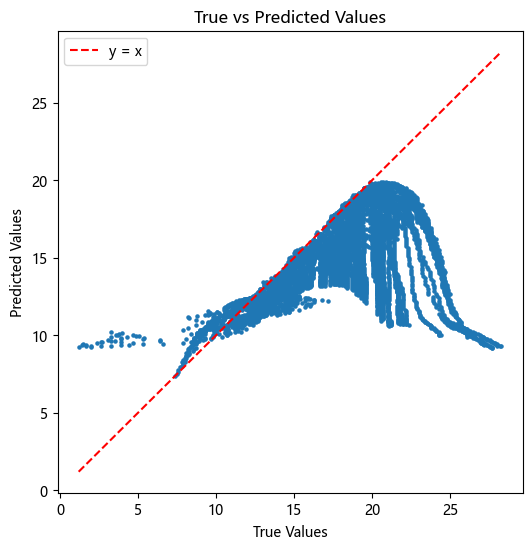

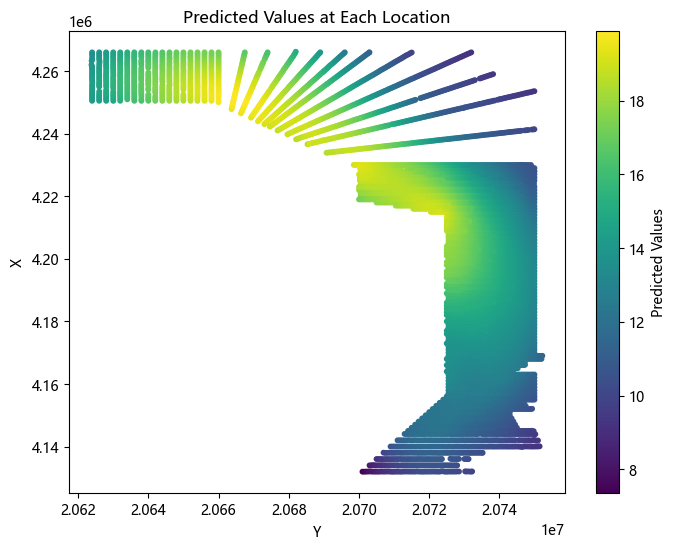

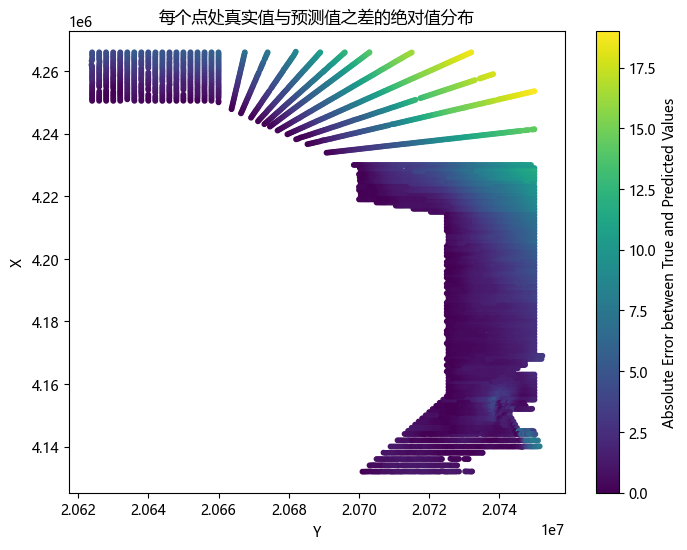

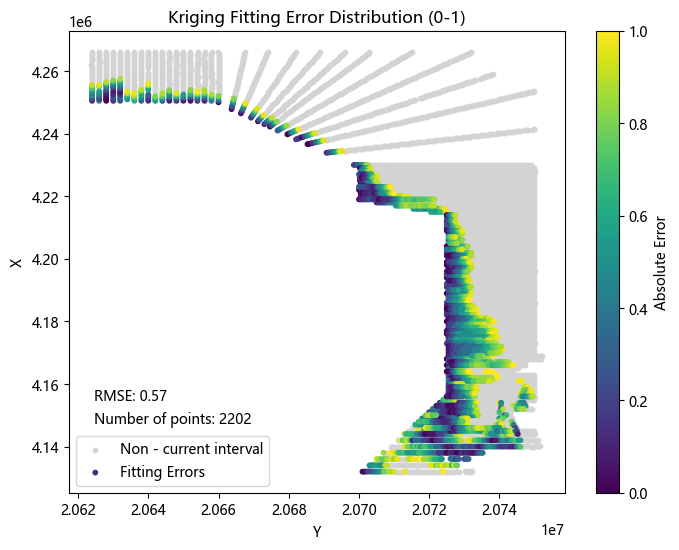

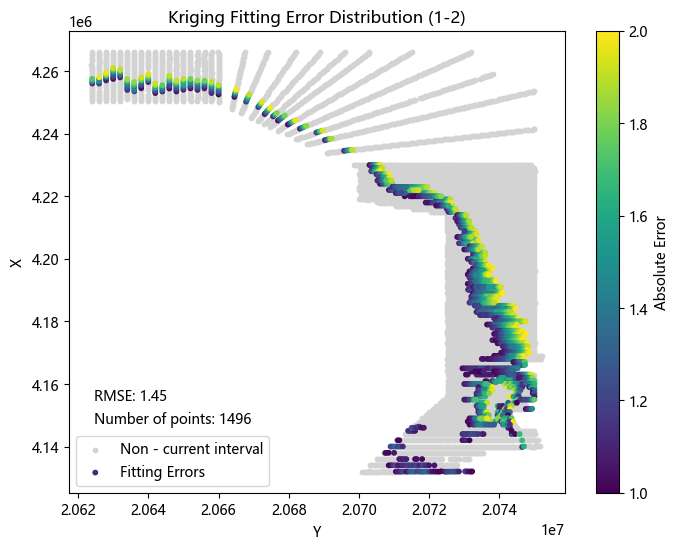

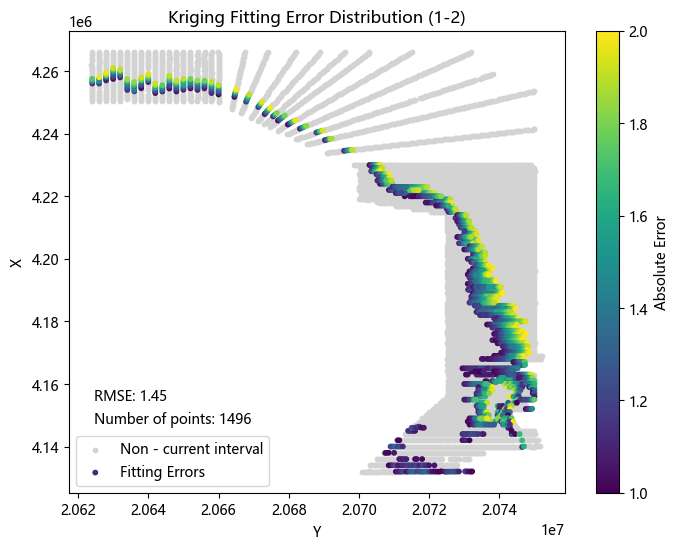

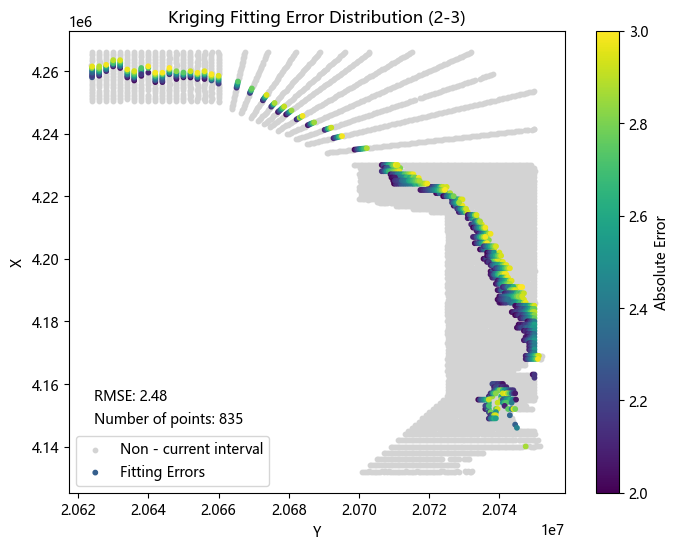

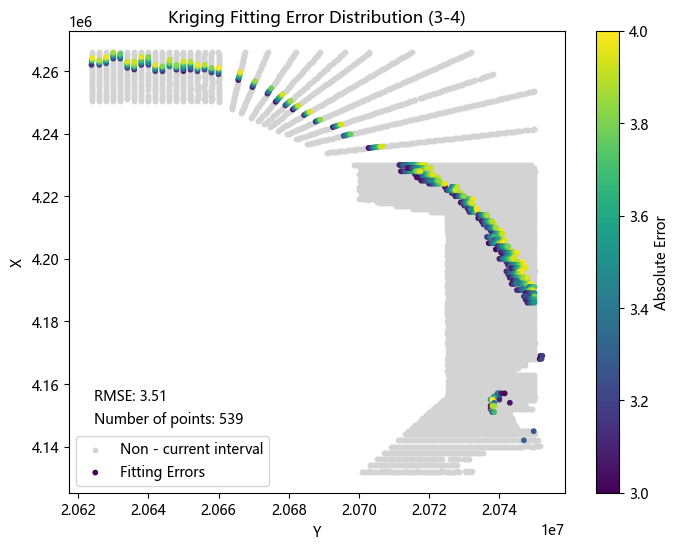

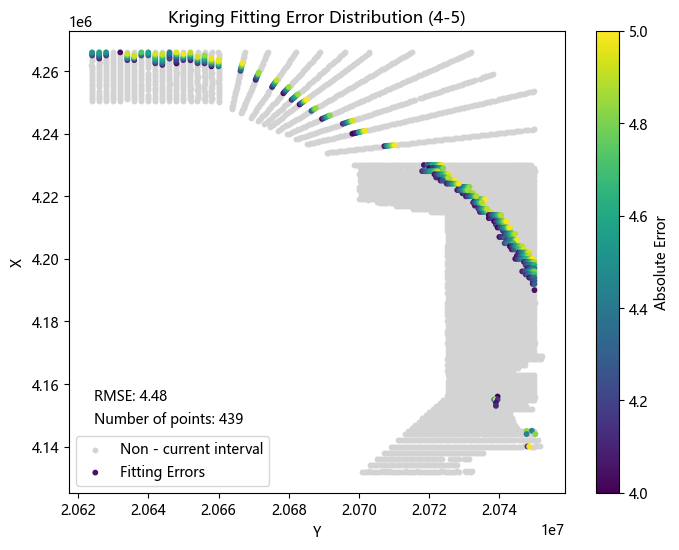

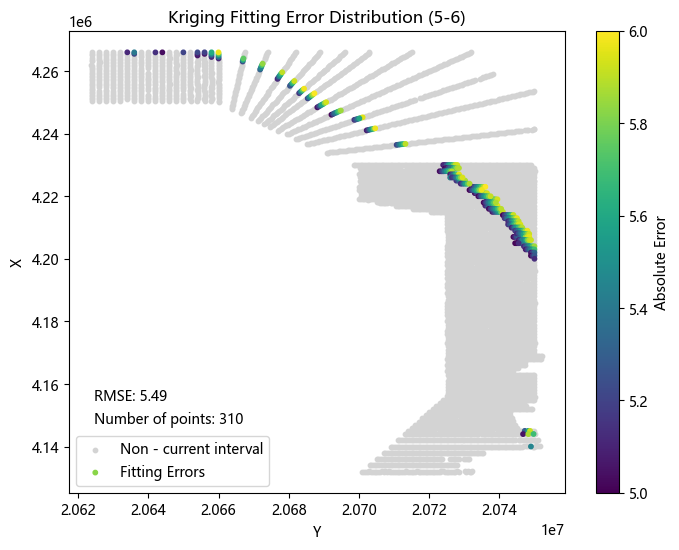

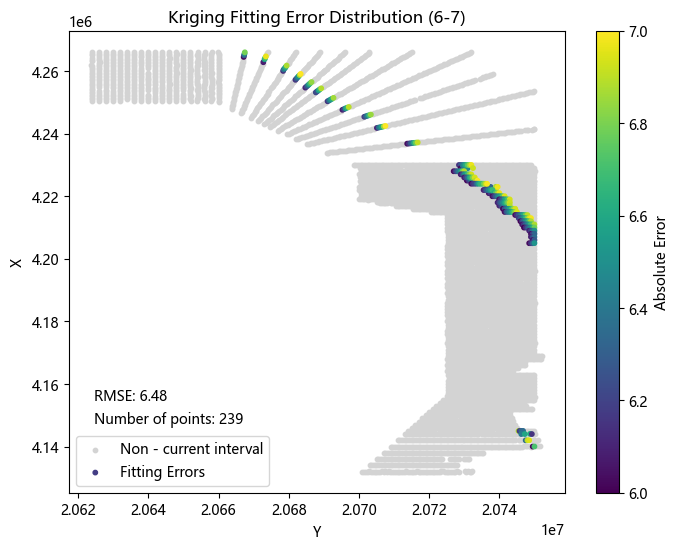

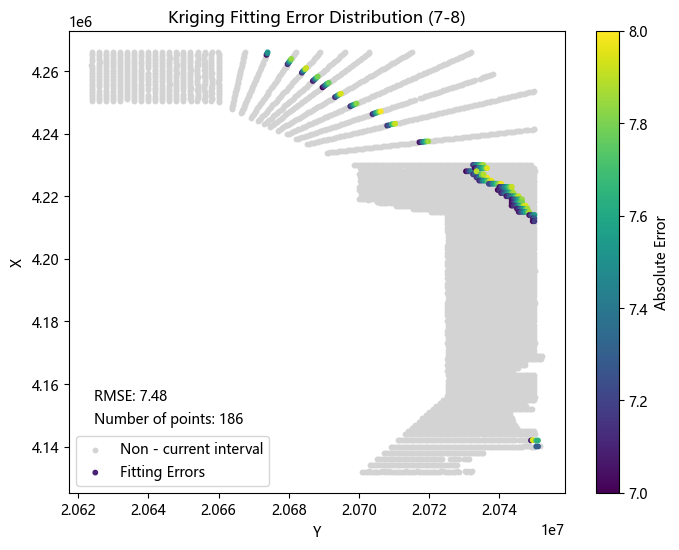

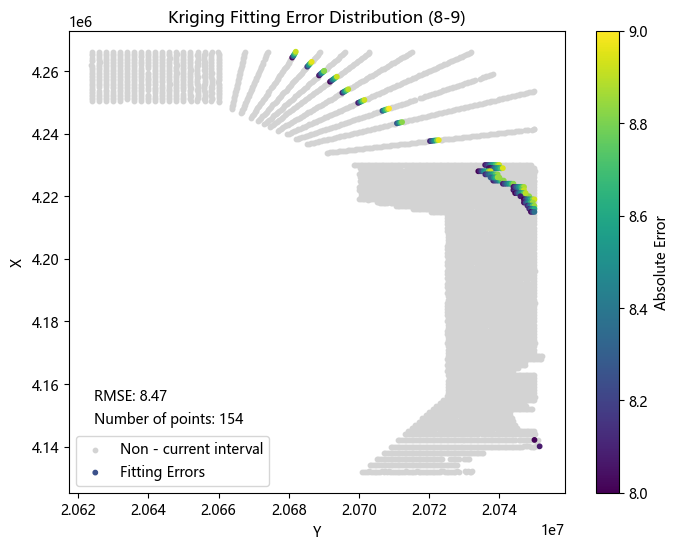

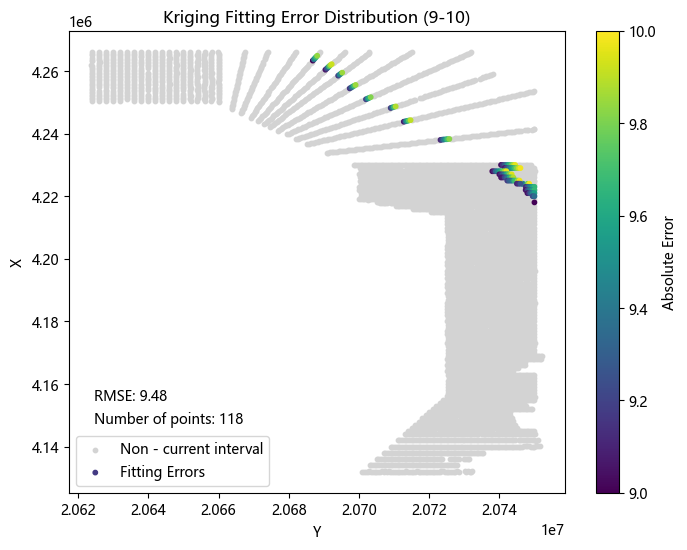

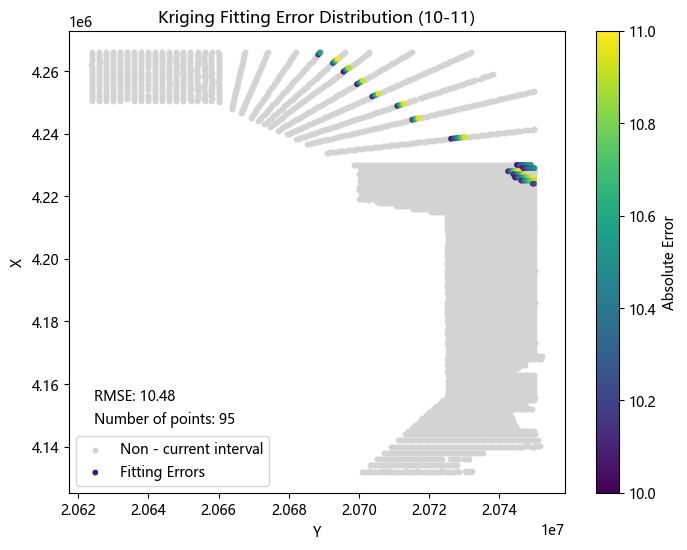

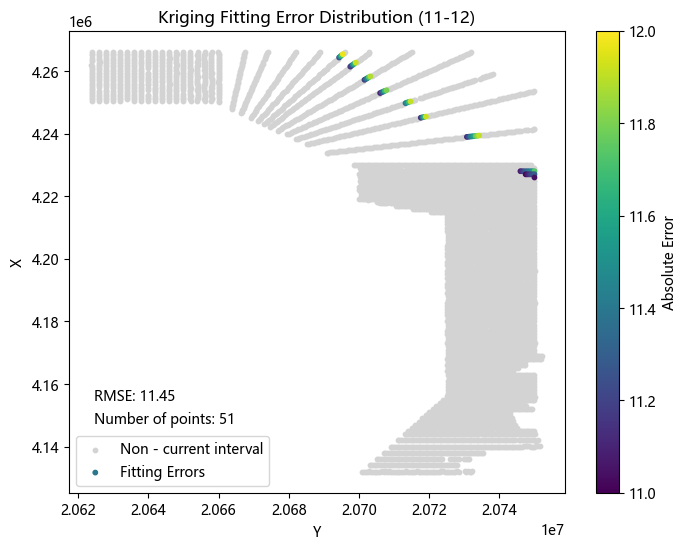

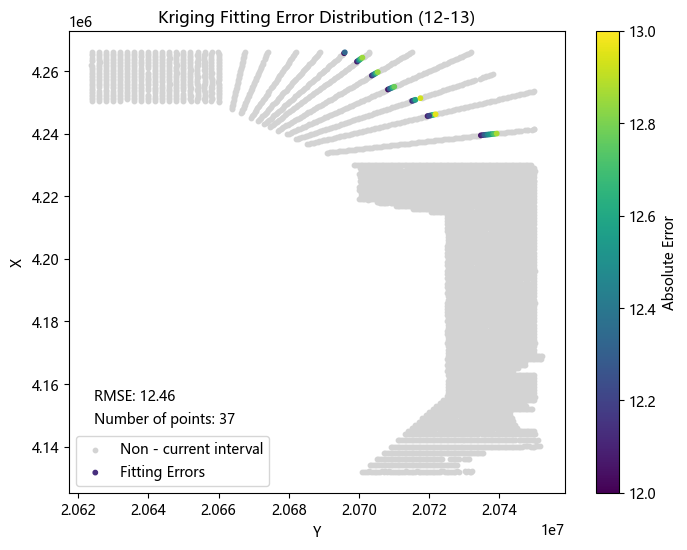

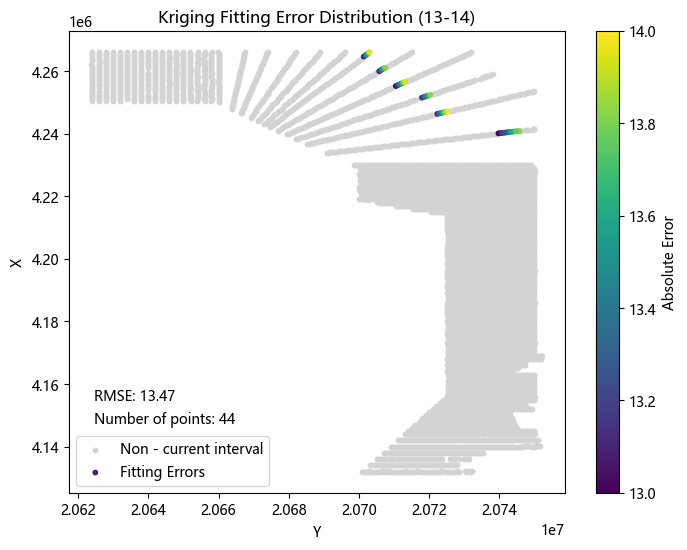

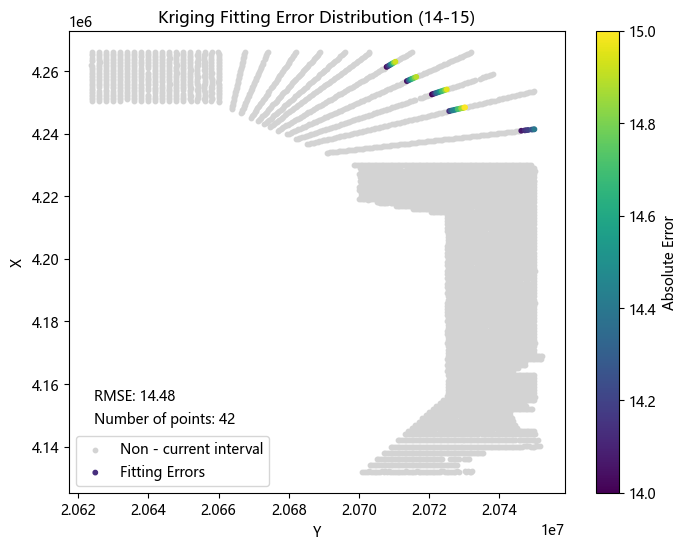

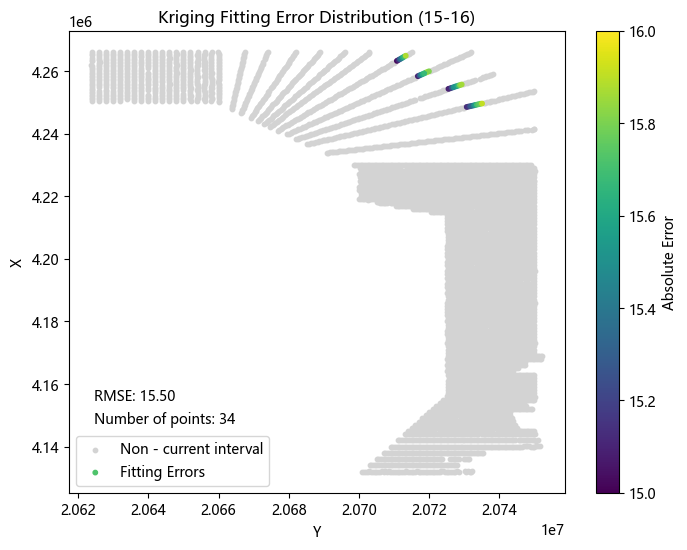

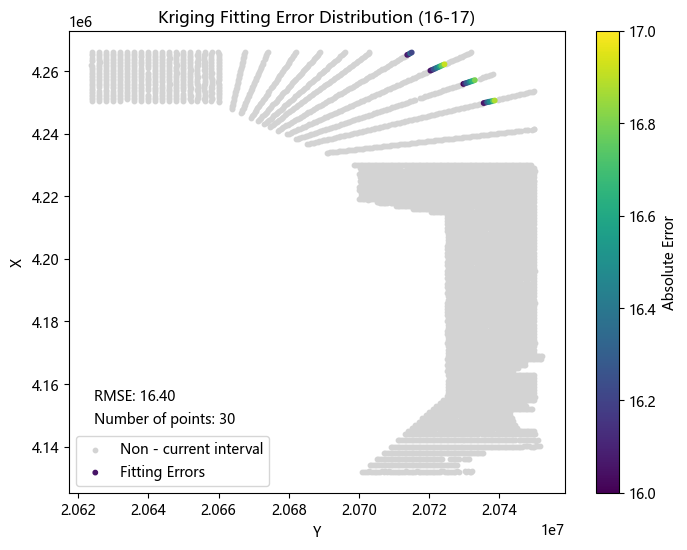

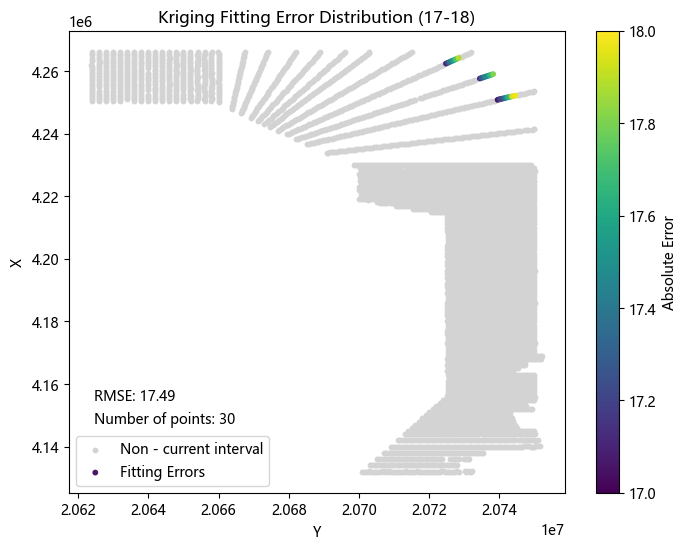

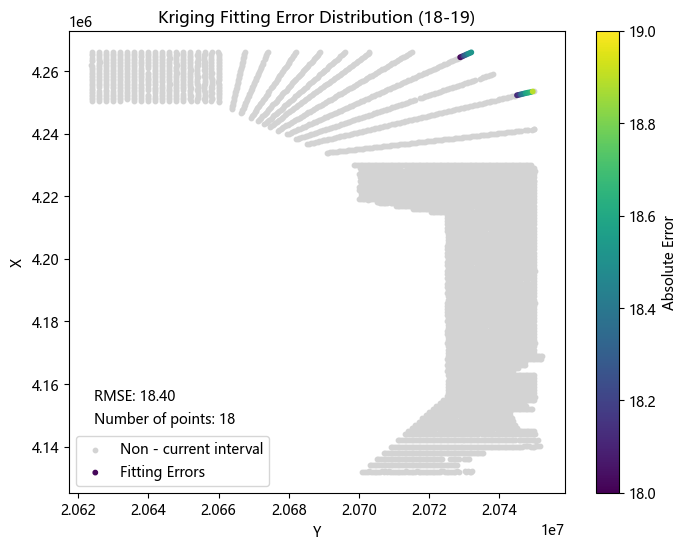

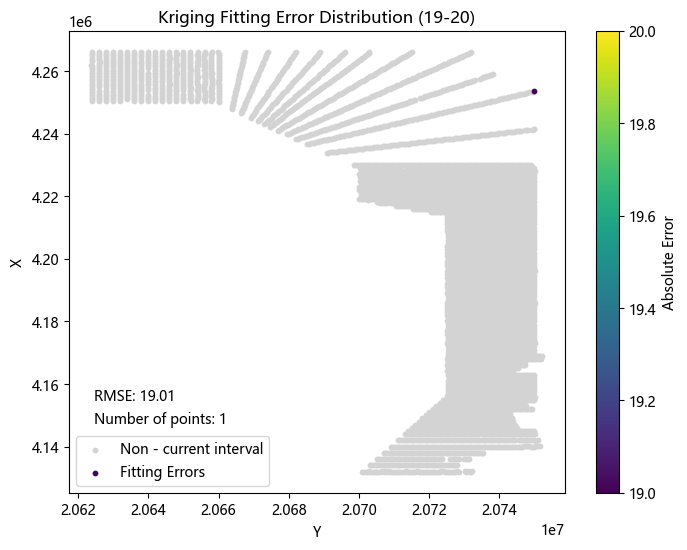

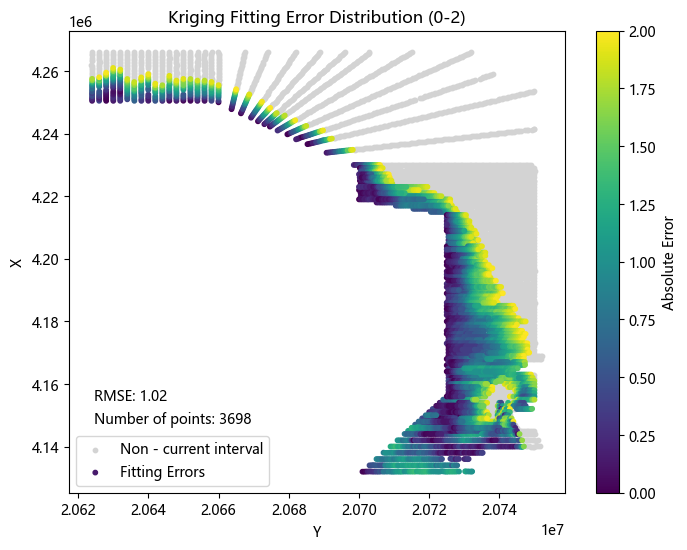

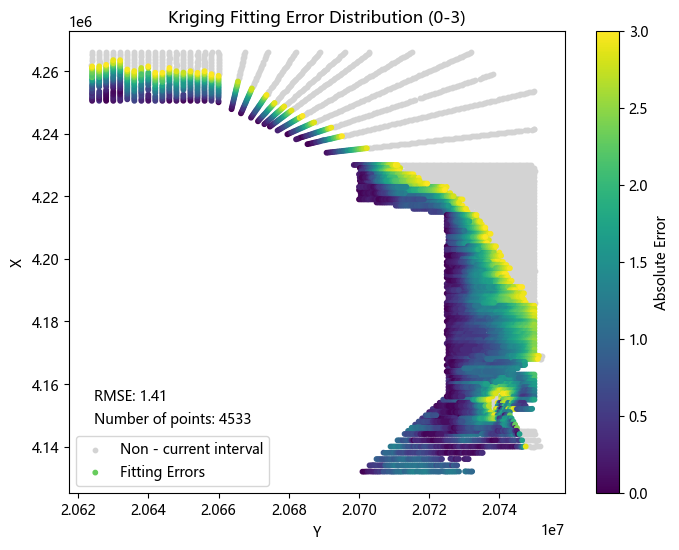

插值结果已保存到csv文件中。


: 

In [ ]:
#OK残差可视化分布
import numpy as np
import pandas as pd
from pykrige.ok import OrdinaryKriging
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# 设置中文字体
plt.rcParams['font.family'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False

def kriging_interpolation(known_file, unknown_file, chunk_size=1000):
    # 读取已知数据
    known_data = pd.read_csv(known_file)
    x_known = known_data['X'].values.astype(np.float64)
    y_known = known_data['Y'].values.astype(np.float64)
    z_known = known_data['水深'].values.astype(np.float64)

    # 读取未知数据
    unknown_data = pd.read_csv(unknown_file)
    x_unknown = unknown_data['X'].values.astype(np.float64)
    y_unknown = unknown_data['Y'].values.astype(np.float64)

    z_interp_chunks = []
    sigmasq_chunks = []

    # 分块处理未知数据
    for i in range(0, len(x_unknown), chunk_size):
        start = i
        end = min(i + chunk_size, len(x_unknown))
        x_unknown_chunk = x_unknown[start:end]
        y_unknown_chunk = y_unknown[start:end]

        # 创建普通克里金插值对象
        OK = OrdinaryKriging(
            x_known, y_known, z_known,
            variogram_model='spherical',
        )

        # 对当前块进行插值
        z_interp_chunk, sigmasq_chunk = OK.execute('points', x_unknown_chunk, y_unknown_chunk)
        z_interp_chunks.append(z_interp_chunk)
        sigmasq_chunks.append(sigmasq_chunk)

    # 合并插值结果
    z_interp = np.concatenate(z_interp_chunks)
    sigmasq = np.concatenate(sigmasq_chunks)

    # 判断未知数据中是否包含水深列
    if '水深' in unknown_data.columns:
        z_true = unknown_data['水深'].values
        # 计算总的 RMSE
        rmse = np.sqrt(mean_squared_error(z_true, z_interp))
        print(f"总的 RMSE: {rmse}")

        # 分别筛选水深大于 15 和小于 15 的数据
        mask_gt_15 = z_true > 15
        mask_lt_15 = z_true < 15

        z_true_gt_15 = z_true[mask_gt_15]
        z_interp_gt_15 = z_interp[mask_gt_15]
        z_true_lt_15 = z_true[mask_lt_15]
        z_interp_lt_15 = z_interp[mask_lt_15]

        # 计算水深大于 15 的 RMSE
        if len(z_true_gt_15) > 0:
            rmse_gt_15 = np.sqrt(mean_squared_error(z_true_gt_15, z_interp_gt_15))
            print(f"水深大于 15 的 RMSE: {rmse_gt_15}")
        else:
            print("没有水深大于 15 的数据，无法计算 RMSE。")

        # 计算水深小于 15 的 RMSE
        if len(z_true_lt_15) > 0:
            rmse_lt_15 = np.sqrt(mean_squared_error(z_true_lt_15, z_interp_lt_15))
            print(f"水深小于 15 的 RMSE: {rmse_lt_15}")
        else:
            print("没有水深小于 15 的数据，无法计算 RMSE。")

        # 计算每个点真实值与预测值之差的绝对值
        errors = np.abs(z_true - z_interp)

        # 筛选误差在0-3区间的数据
        mask_0_3 = (errors >= 0) & (errors < 3)
        z_true_0_3 = z_true[mask_0_3]
        z_interp_0_3 = z_interp[mask_0_3]

        # 计算0-3区间的RMSE
        if len(z_true_0_3) > 0:
            rmse_0_3 = np.sqrt(mean_squared_error(z_true_0_3, z_interp_0_3))
            print(f"误差在0-3区间的 RMSE: {rmse_0_3}")
        else:
            print("没有误差在0-3区间的数据，无法计算 RMSE。")

        # 可视化真实值与预测值
        plt.figure(figsize=(6, 6))
        plt.scatter(z_true, z_interp, s=5)
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title('True vs Predicted Values')

        # 绘制 y = x 直线
        min_val = min(np.min(z_true), np.min(z_interp))
        max_val = max(np.max(z_true), np.max(z_interp))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')
        plt.legend()
        plt.show()

        # 可视化每个位置点的预测值
        plt.figure(figsize=(8, 6))
        norm = plt.Normalize(vmin=np.min(z_interp), vmax=np.max(z_interp))
        cmap = plt.get_cmap('viridis')
        # 调换 XY 轴
        scatter = plt.scatter(y_unknown, x_unknown, c=z_interp, cmap=cmap, norm=norm, s=10)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Predicted Values')
        # 调换 XY 轴标签
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.title('Predicted Values at Each Location')
        plt.show()

        # 可视化每个点处真实值与预测值之差的绝对值
        plt.figure(figsize=(8, 6))
        norm = plt.Normalize(vmin=0, vmax=np.max(errors))
        cmap = plt.get_cmap('viridis')
        # 调换 XY 轴
        scatter = plt.scatter(y_unknown, x_unknown, c=errors, cmap=cmap, norm=norm, s=10)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error between True and Predicted Values')
        # 调换 XY 轴标签
        plt.xlabel('Y')
        plt.ylabel('X')
        plt.title('每个点处真实值与预测值之差的绝对值分布')
        plt.show()

        # 定义误差分级区间
        max_error = np.max(errors)
        num_intervals = int(np.ceil(max_error)) + 1

        def plot_error_interval(lower_bound, upper_bound):
            # 筛选当前区间的点
            current_mask = (errors >= lower_bound) & (errors < upper_bound)
            # 筛选非当前区间的点
            non_current_mask = ~current_mask

            z_true_current = z_true[current_mask]
            z_interp_current = z_interp[current_mask]

            # 计算当前区间的 RMSE
            if len(z_true_current) > 0:
                rmse_current = np.sqrt(mean_squared_error(z_true_current, z_interp_current))
            else:
                rmse_current = None

            # 设置颜色映射与归一化
            norm = plt.Normalize(vmin=lower_bound, vmax=upper_bound)
            cmap = plt.get_cmap('viridis')
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

            # 可视化真实值与预测值，并按误差分级显示颜色
            plt.figure(figsize=(8, 6))
            # 绘制非当前区间的点，颜色设为浅灰色
            # 调换 XY 轴
            plt.scatter(y_unknown[non_current_mask], x_unknown[non_current_mask], c='lightgray', s=10, label='Non - current interval')
            # 绘制当前区间的点
            # 调换 XY 轴
            scatter = plt.scatter(y_unknown[current_mask], x_unknown[current_mask], c=errors[current_mask], cmap=cmap, norm=norm,
                                  label='Fitting Errors', s=10)
            cbar = plt.colorbar(scatter)
            cbar.set_label('Absolute Error')
            # 调换 XY 轴标签
            plt.xlabel('Y')
            plt.ylabel('X')
            plt.title(f'Kriging Fitting Error Distribution ({lower_bound}-{upper_bound})')
            if rmse_current is not None:
                # 将 RMSE 与点数的标签置于左下角
                plt.text(0.05, 0.2, f'RMSE: {rmse_current:.2f}', transform=plt.gca().transAxes)
                plt.text(0.05, 0.15, f'Number of points: {len(z_true_current)}', transform=plt.gca().transAxes)
            plt.legend()
            plt.show()

        for i in range(num_intervals):
            if i == 0:
                lower_bound = 0
                upper_bound = 1
            elif i == 1:
                lower_bound = 1
                upper_bound = 2
            else:
                lower_bound = i - 1
                upper_bound = i

            plot_error_interval(lower_bound, upper_bound)

        # 额外显示 0-2 及 0-3 对应的点分布及其 RMSE 与点数量
        for upper in [2, 3]:
            lower_bound = 0
            upper_bound = upper
            plot_error_interval(lower_bound, upper_bound)

    else:
        print("未知数据中不包含水深列，不计算 RMSE，也无法进行可视化。")

    # 将插值结果作为新列添加到原始的 unknown_data 中
    unknown_data['预测水深'] = z_interp
    # 将修改后的 DataFrame 保存到新的 CSV 文件
    unknown_data.to_csv('E:/Desktop/duozhong/b_bisheng2/csv/OK_2015_tu_mi.csv', index=False)
    print("插值结果已保存到csv文件中。")


# 调用函数进行插值
known_file = 'E:/Desktop/duozhong/b_bisheng2/csv/2015_nei.csv'
unknown_file = 'E:/Desktop/duozhong/b_bisheng2/csv/2015_tu_mi.csv'
kriging_interpolation(known_file, unknown_file)
    
#OK残差可视化分布